# Difftest Results

Connect to results database:

In [1]:
import db
from db import *
%run util.py

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLgen", "CLgen w. cl_launcher", "CLgen w. co"]
TABLES = [CLSmithResult, CLgenResult, cl_launcherCLgenResult, coCLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES]),
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLgen,CLgen w. cl_launcher,CLgen w. co
#. Programs,10001,18183,2385,3385
#. Testbeds,10,9,7,7
#. Params,4,4,4,4
#. Results,298265,355015,66780,53840


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

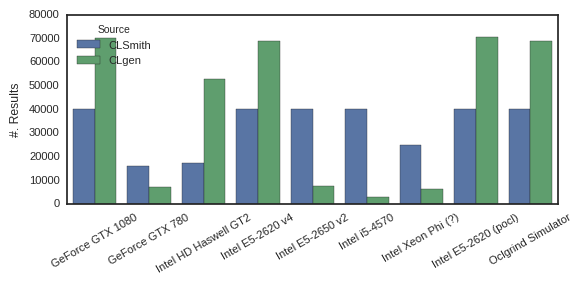

In [3]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from labm8 import viz

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

def get_testbed_info(config_id, testbed_id, source, results_table):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    num_results = session.query(results_table).filter(results_table.testbed_id == testbed_id).count()
    return {
        "Device": device_str(testbed.device),
        "#. Results": num_results,
        "Source": source,
    }

data = []
for source, table in [("CLSmith", CLSmithResult), ("CLgen", CLgenResult)]:
    data += [get_testbed_info(*x, source, table) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="#. Results", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("#. Results")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
viz.finalise(figsize=(6, 3))

/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


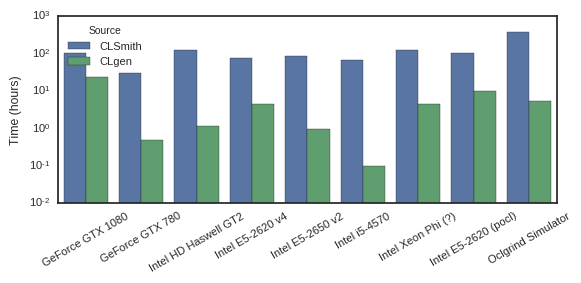

In [4]:
def get_testbed_info(config_id, testbed_id, source, results_table, program_table, reduction_table, harness_table=None):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    total_time = session.query(sql.sql.func.sum(results_table.runtime))\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
    total_time += session.query(sql.sql.func.sum(reduction_table.runtime))\
        .join(results_table)\
        .filter(results_table.testbed_id == testbed_id).first()[0] or 0
#     if harness_table:
#         total_time += session.query(sql.sql.func.sum(harness_table.generation_time)).filter(Testbed.id == testbed_id).first()[0] or 0
    return {
        "Device": device_str(testbed.device),
        "Test Time": total_time / 3600,
        "Source": source,
    }

data = []
for row in [("CLSmith", CLSmithResult, CLSmithProgram, CLSmithReduction), 
                       ("CLgen", CLgenResult, CLgenProgram, CLgenReduction, CLgenHarness)]:
    data += [get_testbed_info(*x, *row) for x in CONFIGURATIONS]
ax = sns.barplot(x="Device", y="Test Time", hue="Source", data=pd.DataFrame(data))
plt.xlabel("")
plt.ylabel("Time (hours)")
plt.setp(ax.get_xticklabels(), rotation=30)  # rotate x ticks
ax.set_yscale("log", nonposy='clip')
viz.finalise(figsize=(6, 3))

In [5]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase

import os
from collections import OrderedDict

def get_platform_stats(testbed: Testbed):
    submitable_results = [coCLgenResult, cl_launcherCLgenResult]
    
    def get_submitted(table):
        return session.query(table).filter(table.testbed_id == testbed.id, table.submitted).count()

    def get_generated(table):
        return session.query(table).filter(table.testbed_id == testbed.id, sql.or_(table.submitted, table.dupe)).count()

    runtime_tables = [coCLgenResult, CLgenResult, cl_launcherCLgenResult]
    def get_runtime(table):
        return session.query(sql.sql.func.sum(table.runtime)).filter(table.testbed_id == testbed.id).first()[0] or 0

    return (
        sum(get_generated(table) for table in submitable_results), 
        sum(get_submitted(table) for table in submitable_results),
        sum(get_runtime(table) for table in runtime_tables),
    )


def get_row(config_id, testbed_id):
    testbed = session.query(Testbed).filter(Testbed.id == testbed_id).first()
    d = OrderedDict()
    d["#."] = config_id
    d["Device"] = testbed.device
    d["Platform"] = platform_str(testbed.platform)
    d["Driver"] = driver_str(testbed.driver)
    d["OpenCL"] = testbed.opencl
    d["Operating system"] = host_str(testbed.host)
    d["Device type"] = devtype_str(testbed.devtype)
    generated, submitted, runtime = get_platform_stats(testbed)
    d["Testing time"] = "{:.0f}h".format(round(runtime / 3600))
    d["B.R. Generated"] = generated
    d["B.R. Submitted"] = submitted
    return d

table = pd.DataFrame([get_row(*x) for x in CONFIGURATIONS])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile, index=None)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
[master 8ecd4f2] auto: build/tab/platforms.tex
 1 file changed, 7 insertions(+), 7 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 495 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   f3a516d..8ecd4f2  master -> master


,#.,Device,Platform,Driver,OpenCL,Operating system,Device type,Testing time,B.R. Generated,B.R. Submitted
0,1,GeForce GTX 1080,NVIDIA CUDA,375.39,1.2,Ubuntu 16.04 64bit,GPU,30h,13,7
1,2,GeForce GTX 780,NVIDIA CUDA,361.42,1.2,openSUSE 13.1 64bit,GPU,0h,0,0
2,3,Intel(R) HD Graphics Haswell GT2 Desktop,Intel Gen OCL Driver,1.3,1.2,Ubuntu 16.04 64bit,GPU,2h,35,11
3,4,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,Intel OpenCL,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU,10h,10,5
4,5,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,Intel OpenCL,1.2.0.44,1.2,CentOS 7.1 64bit,CPU,7h,2,1
5,6,Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz,Intel OpenCL,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU,1h,4,4
6,7,Intel(R) Many Integrated Core Acceleration Card,Intel OpenCL,1.2,1.2,CentOS 7.1 64bit,Accelerator,11h,0,0
7,8,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,POCL,0.14,2.0,Ubuntu 16.04 64bit,CPU,15h,170,52
8,9,Oclgrind Simulator,Oclgrind,16.10,1.2,Ubuntu 16.04 64bit,Emulator,9h,0,0


In [6]:
%run mkmegatable.ipy

insufficient CLgenResults for GeForce GTX 1080 True
insufficient CLgenResults for GeForce GTX 1080 False
insufficient CLSmithResults for GeForce GTX 780 True
insufficient CLgenResults for GeForce GTX 780 True
insufficient CLSmithResults for GeForce GTX 780 False
insufficient CLgenResults for GeForce GTX 780 False
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop True
insufficient CLgenResults for Intel(R) HD Graphics Haswell GT2 Desktop False
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz True
insufficient CLgenResults for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz False
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz True
insufficient CLgenResults for       Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz False
insufficient CLSmithResults for Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz True
insufficient CLgenResults for Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz True
insufficient CLgenResults for Intel(R) Core(TM) i5-4570 CP

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


## Runtimes

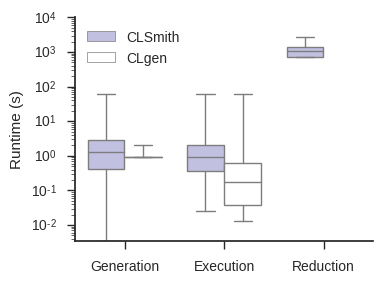

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/runtimes.pdf
[master c48736b] auto: build/img/runtimes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.63 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   8ecd4f2..c48736b  master -> master


In [7]:
sns.set(style="ticks")

def plot_runtimes(*args, **kwargs):
    TIMEOUT = 60
    
    # CLSmith times
    q = session.query(
            CLSmithResult.runtime, 
            CLSmithProgram.runtime, 
            sql.sql.func.ifnull(CLSmithReduction.runtime, 0))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None)
    clsmith_times = np.array([row for row in q])
    
    # CLgen times
    q = session.query(
            CLgenResult.runtime,
            sql.sql.func.ifnull(CLgenProgram.runtime, clgen_generation_time) + CLgenHarness.generation_time,
            sql.sql.func.ifnull(CLgenReduction.runtime, 0))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenHarness)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None)
    clgen_times = np.array([row for row in q])

    table = (
        [("Execution", x, "CLSmith") for x in clsmith_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLSmith") for x in clsmith_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLSmith") for x in clsmith_times[:,2] if x > 0] +
        [("Execution", x, "CLgen") for x in clgen_times[:,0] if x < TIMEOUT] +
        [("Generation", x, "CLgen") for x in clgen_times[:,1] if x < TIMEOUT] +
        [("Reduction", x, "CLgen") for x in clgen_times[:,2] if x > 0])
    table = pd.DataFrame(table, columns=["Name", "Runtime (s)", "Source"])

    # Plot
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Name", y="Runtime (s)", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["Generation", "Execution", "Reduction"])

    
       # Y axis
    ax.set_yscale("log", nonposy='clip')
    plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)

    viz.finalise(*args, **kwargs)


plot_runtimes(figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_runtimes(fs.path("~/docs/paper-project_b/build/img/runtimes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/runtimes.pdf" && git push

## Kernel sizes

In [8]:
sns.set(style="ticks")
from collections import defaultdict

def get_kernel_sizes():
    TIMEOUT = 60
    
    # CLSmith times
    clsmith = session.query(
            CLSmithResult.classification,
            sql.sql.func.ifnull(CLSmithReduction.src, CLSmithProgram.src))\
        .outerjoin(CLSmithProgram)\
        .outerjoin(CLSmithReduction)\
        .filter(CLSmithResult.classification != None,
                CLSmithResult.classification != "pass")
    
    clgen = session.query(
            CLgenResult.classification,
            sql.sql.func.ifnull(CLgenReduction.src, CLgenProgram.src))\
        .outerjoin(CLgenProgram)\
        .outerjoin(CLgenReduction)\
        .filter(CLgenResult.classification != None,
                CLgenResult.classification != "pass")
    
    table = (
        [(classification, len(src.split('\n')), "CLSmith") for classification, src in clsmith] +
        [(classification, len(src.split('\n')), "CLgen") for classification, src in clgen])
    
    return pd.DataFrame(table, columns=['Classification', 'Line count', 'Source'])

table = get_kernel_sizes()

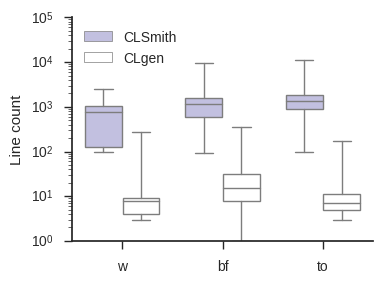

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/kernel-sizes.pdf
[master 674c71d] auto: build/img/kernel-sizes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 2.43 KiB | 0 bytes/s, done.
Total 5 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   c48736b..674c71d  master -> master


In [9]:
def plot_kernel_sizes(table, *args, **kwargs):
    palette = sns.cubehelix_palette(2, rot=0, light=.75, dark=1)
    ax = sns.boxplot(
        x="Classification", y="Line count", hue="Source", data=table,
        width=.75, linewidth=1, fliersize=.5, whis=np.inf, 
        palette=palette, order=["w", "bf", "to"])

    # Y axis
    ax.set_yscale("log", nonposy='clip')
    # plt.ylim((0, 10000))

    # X axis
    plt.xlabel("")
    
    # Legend
    ax.get_legend().set_title("")
    plt.legend(loc='upper left')
    ax.get_legend().draw_frame(False)
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)
    
plot_kernel_sizes(table, figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_kernel_sizes(table, fs.path("~/docs/paper-project_b/build/img/kernel-sizes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/kernel-sizes.pdf" && git push

## Total time

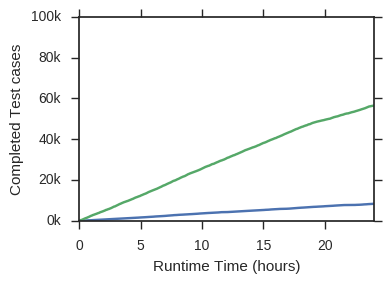

In [10]:
from matplotlib.ticker import FuncFormatter

def plot_totaltime(ax, results_table, programs_table, reductions_table):
    generation_time = sql.sql.func.ifnull(programs_table.runtime, clgen_generation_time)
    runtime = results_table.runtime
    reduction_time = sql.sql.func.ifnull(reductions_table.runtime, 0)
    total_time = generation_time + runtime + reduction_time

    q = session.query(total_time)\
        .outerjoin(programs_table)\
        .outerjoin(reductions_table)\
        .filter(results_table.classification != None)\
        .order_by(results_table.date)

    times = np.array([row[0] / 3600 for row in q]).cumsum()
    ax.plot(times, range(len(times)))
    ax.set_xlim((0, 24))
    ax.set_ylim((0, 100000))

def thousands(x, pos):
    return "{:.0f}k".format(x / 1000)

formatter = FuncFormatter(thousands)
    
ax = plt.gca()
plot_totaltime(ax, CLSmithResult, CLSmithProgram, CLSmithReduction)
plot_totaltime(ax, CLgenResult, CLgenProgram, CLgenReduction)

ax.set_xlabel("Runtime Time (hours)")
ax.set_ylabel("Completed Test cases")
ax.yaxis.set_major_formatter(formatter)
viz.finalise(figsize=(4, 3))